In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import  LassoLarsIC

In [2]:
pd.set_option('display.max_columns', 70)

In [3]:
source_df = pd.read_csv('owid-covid-data.csv')
source_df

iso_code continent     location        date  total_cases  new_cases  \
0           AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1           AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2           AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3           AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4           AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   
...         ...       ...          ...         ...          ...        ...   
231404      ZWE    Africa     Zimbabwe  2022-10-26     257893.0        0.0   
231405      ZWE    Africa     Zimbabwe  2022-10-27     257893.0        0.0   
231406      ZWE    Africa     Zimbabwe  2022-10-28     257893.0        0.0   
231407      ZWE    Africa     Zimbabwe  2022-10-29     257893.0        0.0   
231408      ZWE    Africa     Zimbabwe  2022-10-30     257893.0        0.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                      NaN           NaN         NaN                  NaN   
1                      NaN           NaN         NaN                  NaN   
2                      NaN           NaN         NaN                  NaN   
3                      NaN           NaN         NaN                  NaN   
4                      NaN           NaN         NaN                  NaN   
...                    ...           ...         ...                  ...   
231404                 0.0        5606.0         0.0                  0.0   
231405                 0.0        5606.0         0.0                  0.0   
231406                 0.0        5606.0         0.0                  0.0   
231407                 0.0        5606.0         0.0                  0.0   
231408                 0.0        5606.0         0.0                  0.0   

        total_cases_per_million  new_cases_per_million  \
0                         0.122                  0.122   
1                         0.122                  0.000   
2                         0.122                  0.000   
3                         0.122                  0.000   
4                         0.122                  0.000   
...                         ...                    ...   
231404                15801.745                  0.000   
231405                15801.745                  0.000   
231406                15801.745                  0.000   
231407                15801.745                  0.000   
231408                15801.745                  0.000   

        new_cases_smoothed_per_million  total_deaths_per_million  \
0                                  NaN                       NaN   
1                                  NaN                       NaN   
2                                  NaN                       NaN   
3                                  NaN                       NaN   
4                                  NaN                       NaN   
...                                ...                       ...   
231404                             0.0                   343.494   
231405                             0.0                   343.494   
231406                             0.0                   343.494   
231407                             0.0                   343.494   
231408                             0.0                   343.494   

        new_deaths_per_million  new_deaths_smoothed_per_million  \
0                          NaN                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                          NaN                              NaN   
...                        ...                              ...   
231404                     0.0                              0.0   
231405                     0.0                              0.0   
231406                     0

## 1. Make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

Dataset content:
- total_cases_per_million – Total confirmed cases of COVID-19 per 1,000,000 people
- total_deaths_per_million – Total deaths attributed to COVID-19 per 1,000,000 people
- reproduction_rate – Real-time estimate of the effective reproduction rate (R) of COVID-19
- new_tests_smoothed_per_thousand – New tests for COVID-19 (7-day smoothed) per 1,000 people
- positive_rate – The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)
- new_vaccinations_smoothed_per_million – New COVID-19 vaccination doses administered (7-day smoothed) per 1,000,000 people in the total population
- new_people_vaccinated_smoothed_per_hundred – Daily number of people receiving their first vaccine dose (7-day smoothed) per 100 people in the total population
- gdp_per_capita – Share of the population that is 70 years and older in 2015
- excess_mortality_cumulative – Percentage difference between the cumulative number of deaths since 1 January 2020 and the cumulative projected deaths for the same period based on previous years


In [4]:
source_df.continent.unique()

array(['Asia', nan, 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [5]:
columns = ['continent',
           'reproduction_rate',
           'total_cases_per_million',
            'total_deaths_per_million',
            'new_tests_smoothed_per_thousand',
            'positive_rate',
            'new_vaccinations_smoothed_per_million',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'excess_mortality_cumulative']
df = source_df[columns].copy().dropna()
df.index = np.arange(0, len(df))
df

continent  reproduction_rate  total_cases_per_million  \
0            Europe               1.15                27487.072   
1            Europe               0.92                37704.085   
2            Europe               0.78                44033.426   
3            Europe               0.68                46119.048   
4            Europe               0.61                46551.793   
...             ...                ...                      ...   
3475  South America               1.15               116774.415   
3476  South America               1.61               120773.485   
3477  South America               1.09               195286.251   
3478  South America               0.74               246132.694   
3479  South America               0.65               259418.031   

      total_deaths_per_million  new_tests_smoothed_per_thousand  \
0                      485.519                            1.186   
1                      631.879                            1.316   
2                      786.330                            0.975   
3                      842.270                            0.862   
4                      862.324                            0.989   
...                        ...                              ...   
3475                  1791.226                            2.748   
3476                  1802.620                            3.583   
3477                  1892.897                            7.362   
3478                  2040.729                            3.297   
3479                  2091.565                            2.746   

      positive_rate  new_vaccinations_smoothed_per_million  \
0            0.2470                                    0.0   
1            0.2632                                  371.0   
2            0.1469                                 4265.0   
3            0.0473                                 4300.0   
4            0.0051                                 2580.0   
...             ...                                    ...   
3475         0.0225                                 1299.0   
3476         0.0773                                 1212.0   
3477         0.3930                                 4694.0   
3478         0.2919                                 2021.0   
3479         0.1030                                 2553.0   

      new_people_vaccinated_smoothed_per_hundred  gdp_per_capita  \
0                                          0.000       11803.431   
1                                          0.173       11803.431   
2                                          0.196       11803.431   
3                                          0.196       11803.431   
4                                          0.055       11803.431   
...                                          ...             ...   
3475                                       0.010       20551.409   
3476                                       0.008       20551.409   
3477                                       0.181       20551.409   
3478                                       0.024       20551.409   
3479                                       0.013       20551.409   

      excess_mortality_cumulative  
0                           26.36  
1                           31.33  
2                           34.42  
3                           34.73  
4                           33.50  
...                           ...  
3475                         4.01  
3476                         4.31  
3477                         5.57  
3478                         6.97  
3479                         7.13  

[3480 rows x 10 columns]

In [6]:
target = columns[1]
predictors = columns[2:]
categorial = columns[0] 

In [7]:
df.describe()

reproduction_rate  total_cases_per_million  total_deaths_per_million  \
count        3480.000000              3480.000000               3480.000000   
mean            1.023385            119878.364158               1617.485002   
std             0.273573            110356.207834               1098.611228   
min             0.020000               361.954000                  0.589000   
25%             0.840000             48118.060250                864.040250   
50%             1.000000             83384.094500               1471.639500   
75%             1.180000            143082.995500               2178.229250   
max             4.190000            535610.384000               6235.846000   

       new_tests_smoothed_per_thousand  positive_rate  \
count                      3480.000000    3480.000000   
mean                          6.443801       0.123713   
std                          12.632180       0.130486   
min                           0.026000       0.000000   
25%                           1.312750       0.028600   
50%                           2.859500       0.078100   
75%                           5.448750       0.172575   
max                         147.603000       0.758000   

       new_vaccinations_smoothed_per_million  \
count                            3480.000000   
mean                             3508.352299   
std                              3170.109978   
min                                 0.000000   
25%                              1002.500000   
50%                              2552.000000   
75%                              5319.250000   
max                             21347.000000   

       new_people_vaccinated_smoothed_per_hundred  gdp_per_capita  \
count                                 3480.000000     3480.000000   
mean                                     0.139452    32880.455968   
std                                      0.176462    16852.247576   
min                                      0.000000     5189.972000   
25%                                      0.019000    22669.797000   
50%                                      0.070000    31400.840000   
75%                                      0.190000    44017.591000   
max                                      1.797000    94277.965000   

       excess_mortality_cumulative  
count                  3480.000000  
mean                     13.950828  
std                      13.122035  
min                      -9.920000  
25%                       5.760000  
50%                      10.510000  
75%                      18.350000  
max                      76.550000

In [8]:
from scipy.stats import kde

def kernel_density_estimation(x, bins):
    density = kde.gaussian_kde(x)
    xgrid = np.linspace(x.min(), x.max(), 100)
    mpl.rcParams['figure.dpi'] = 100
    plt.hist(x, bins=bins, density = True)
    plt.plot(xgrid, density(xgrid), 'r-')

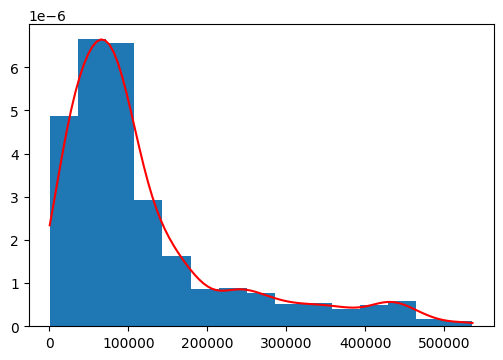

In [9]:
cases = df['total_cases_per_million']
kernel_density_estimation(cases, 15)

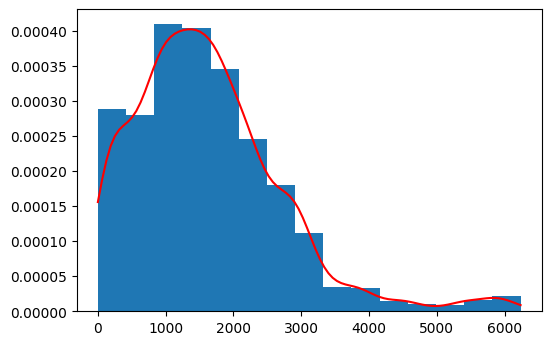

In [10]:
deaths = df['total_deaths_per_million']
kernel_density_estimation(deaths, 15)

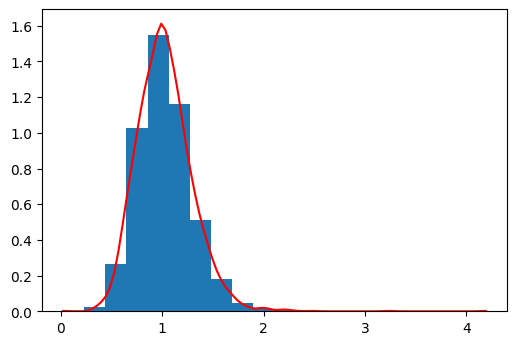

In [11]:
reproduction = df['reproduction_rate']
kernel_density_estimation(reproduction, 20)

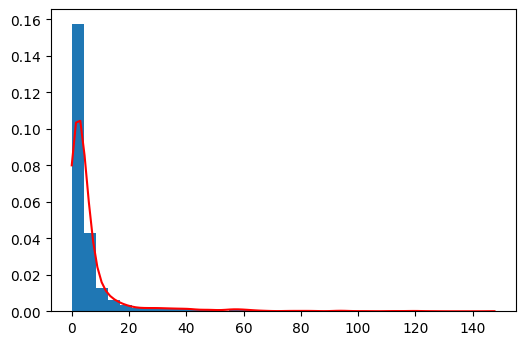

In [12]:
tests = df['new_tests_smoothed_per_thousand']
kernel_density_estimation(tests, 35)

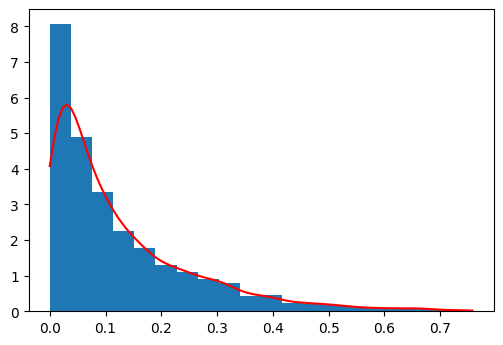

In [13]:
positive = df['positive_rate']
kernel_density_estimation(positive, 20)

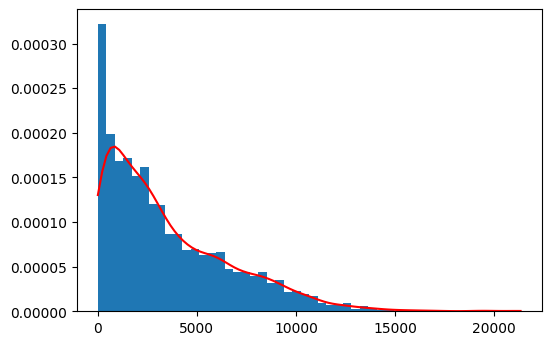

In [14]:
vaccinations = df['new_vaccinations_smoothed_per_million']
kernel_density_estimation(vaccinations, 50)

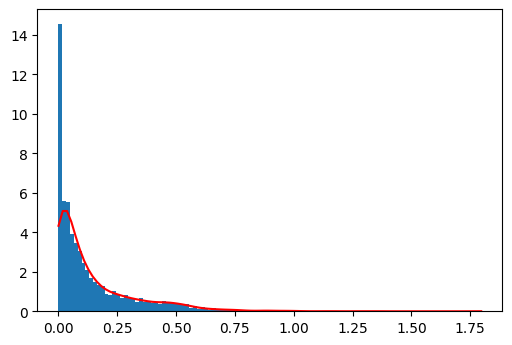

In [15]:
vac_people = df['new_people_vaccinated_smoothed_per_hundred']
kernel_density_estimation(vac_people, 110)

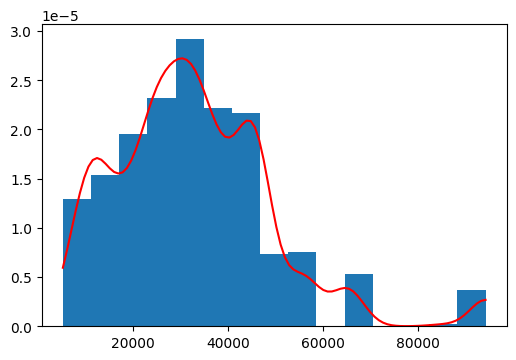

In [16]:
gdp = df['gdp_per_capita']
kernel_density_estimation(gdp, 15)

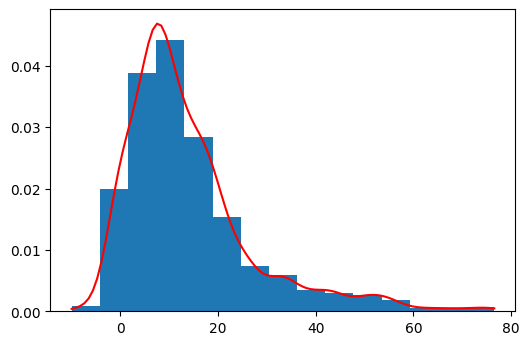

In [17]:
emc = df['excess_mortality_cumulative']
kernel_density_estimation(emc, 15)

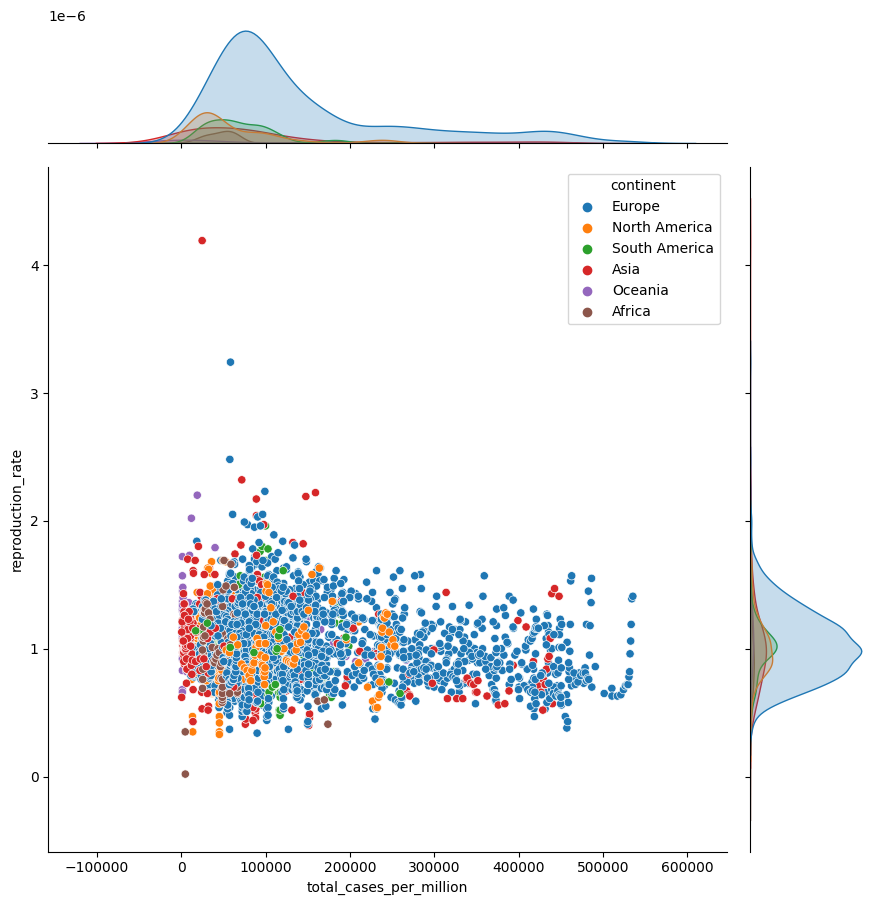

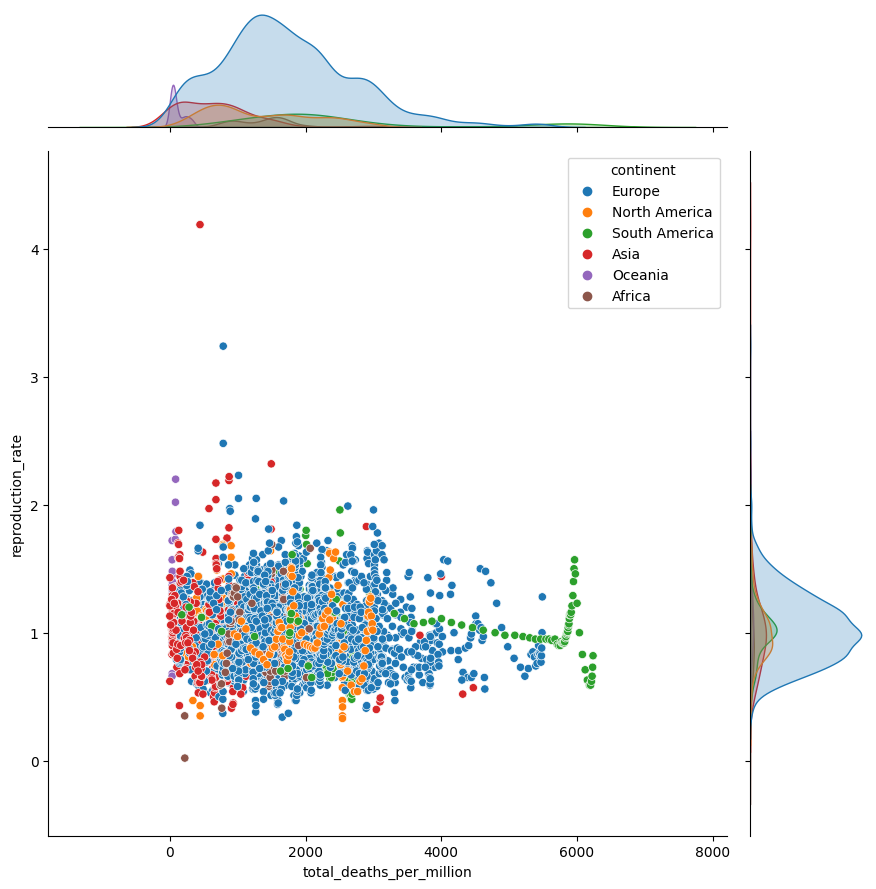

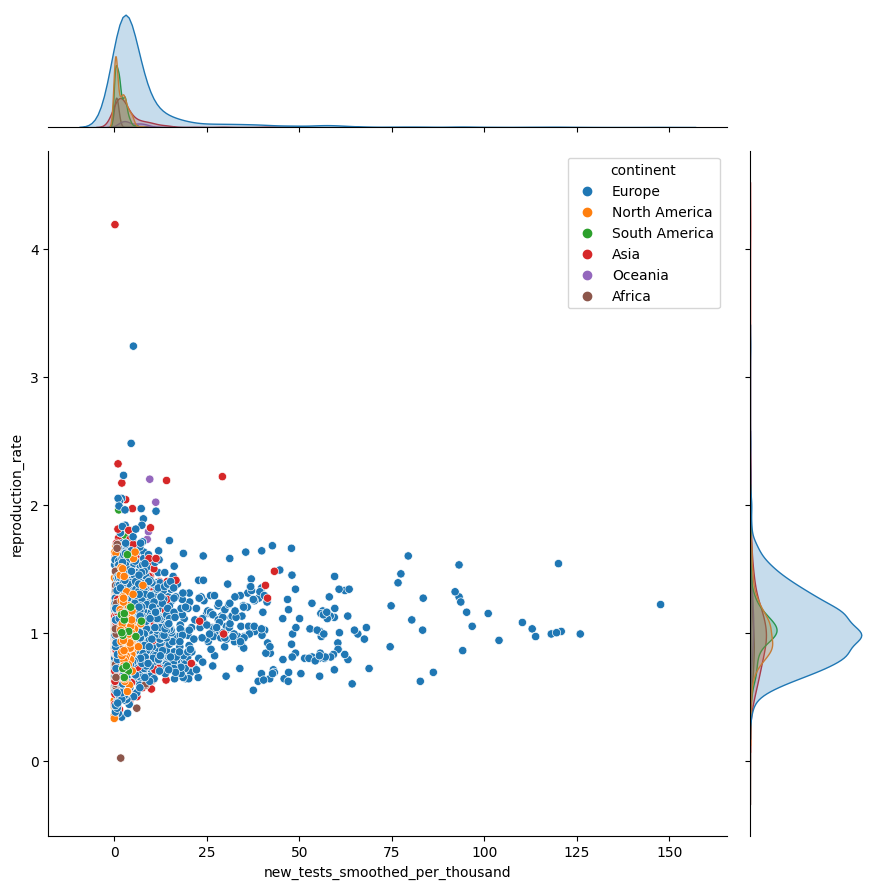

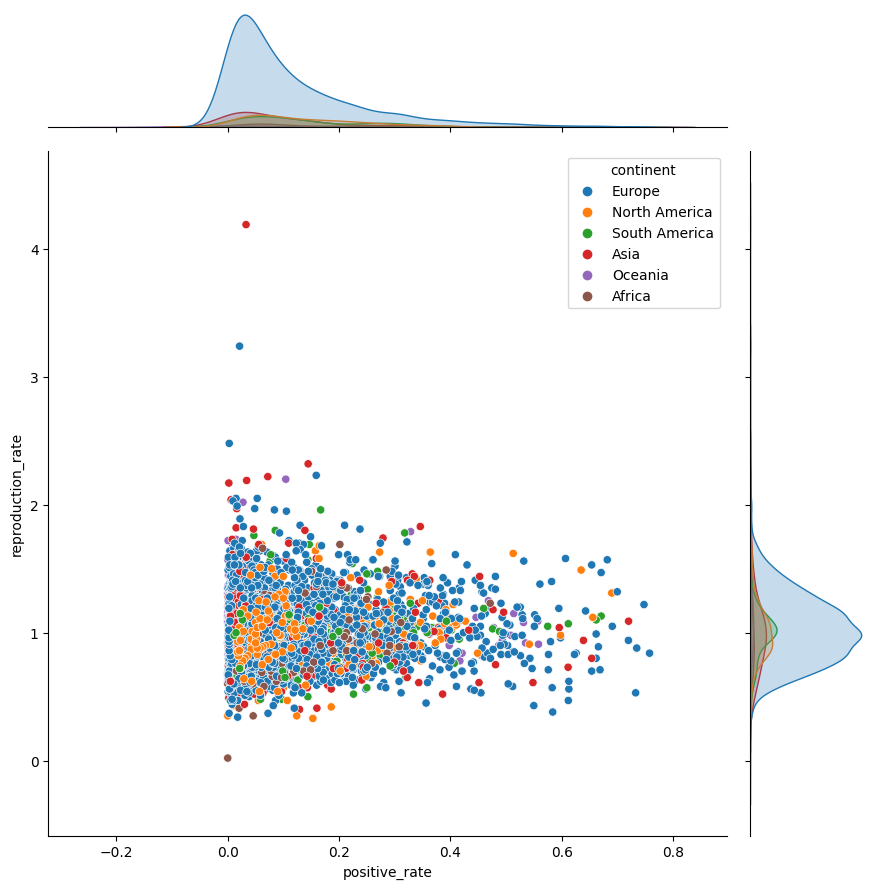

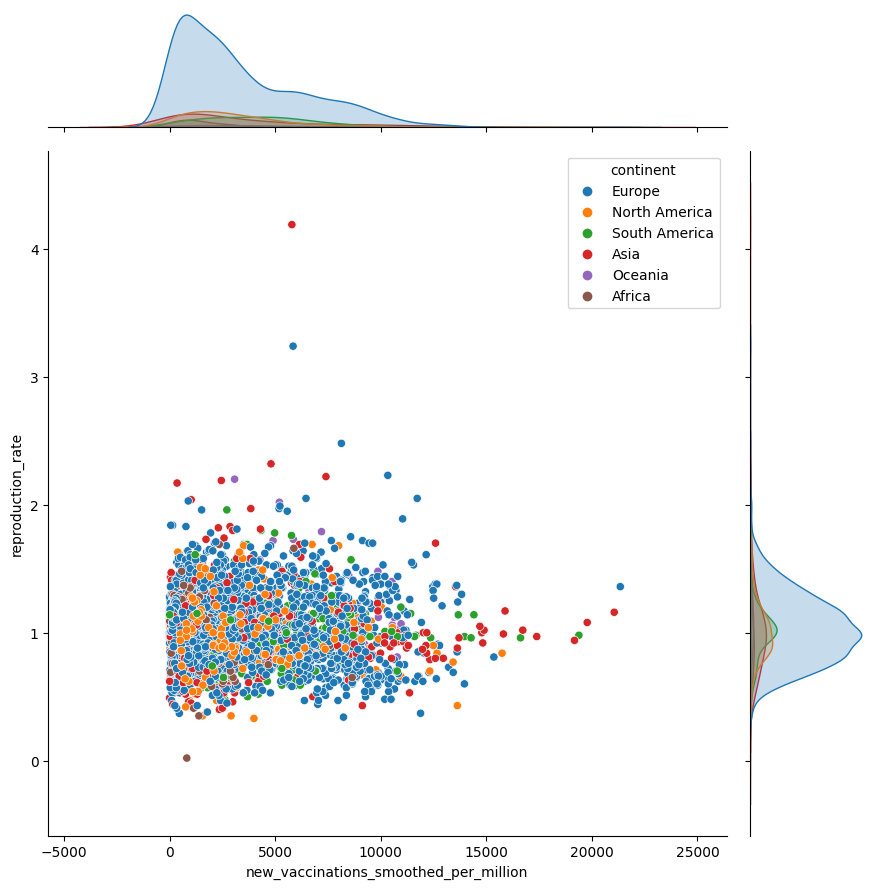

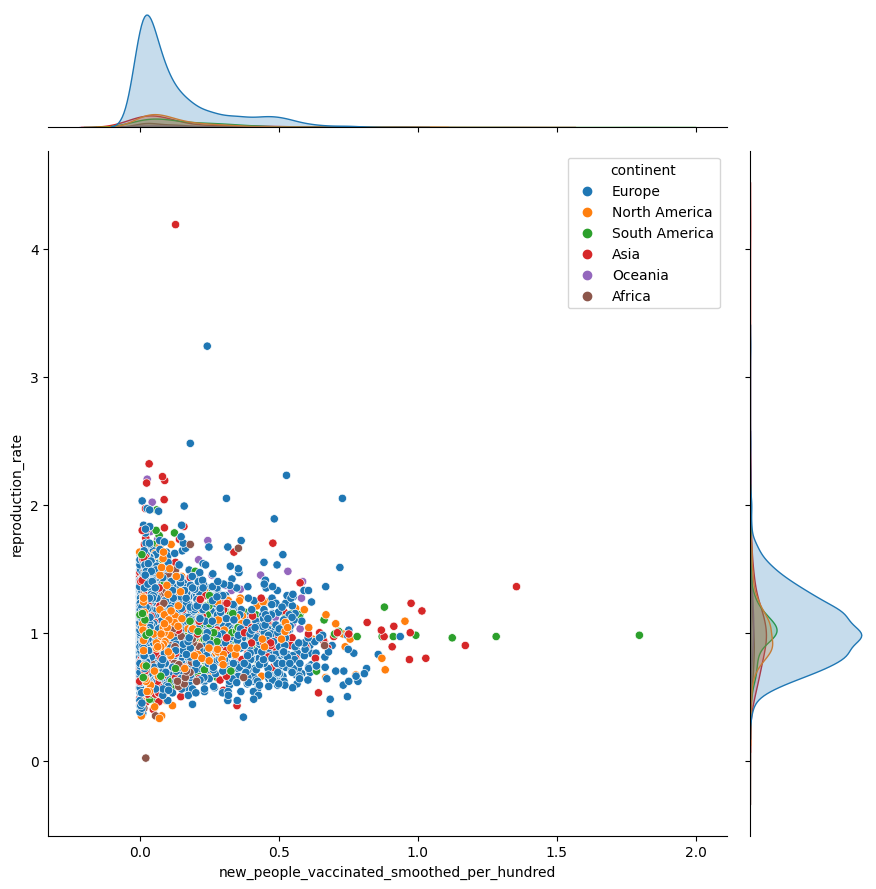

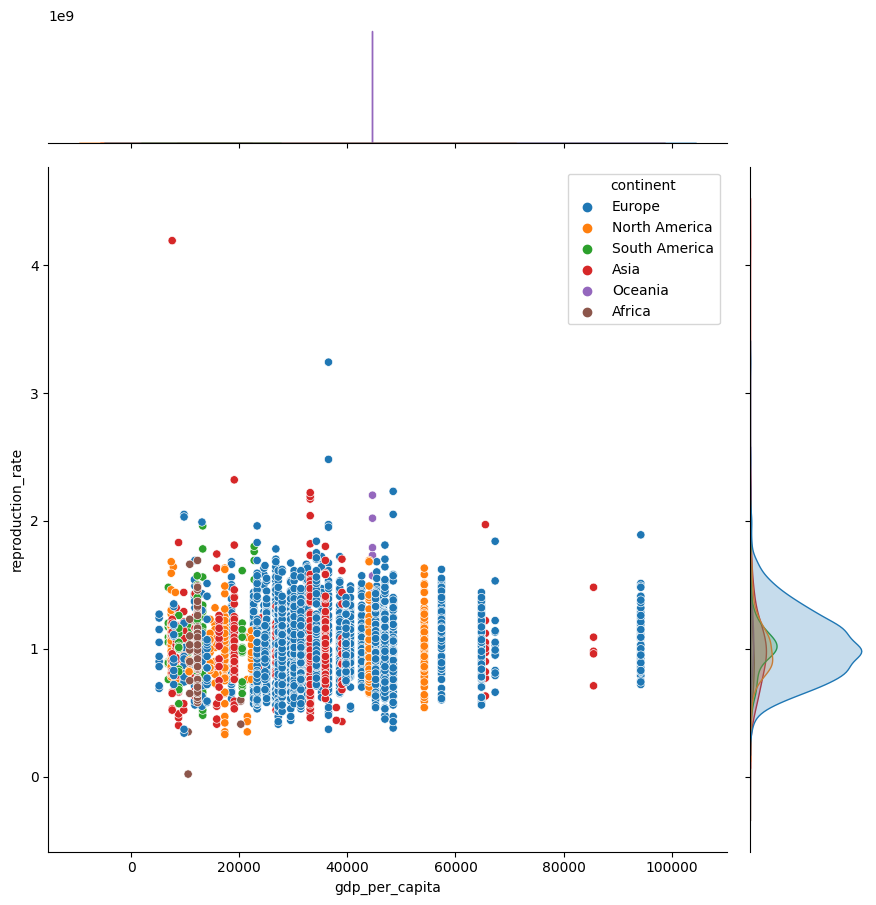

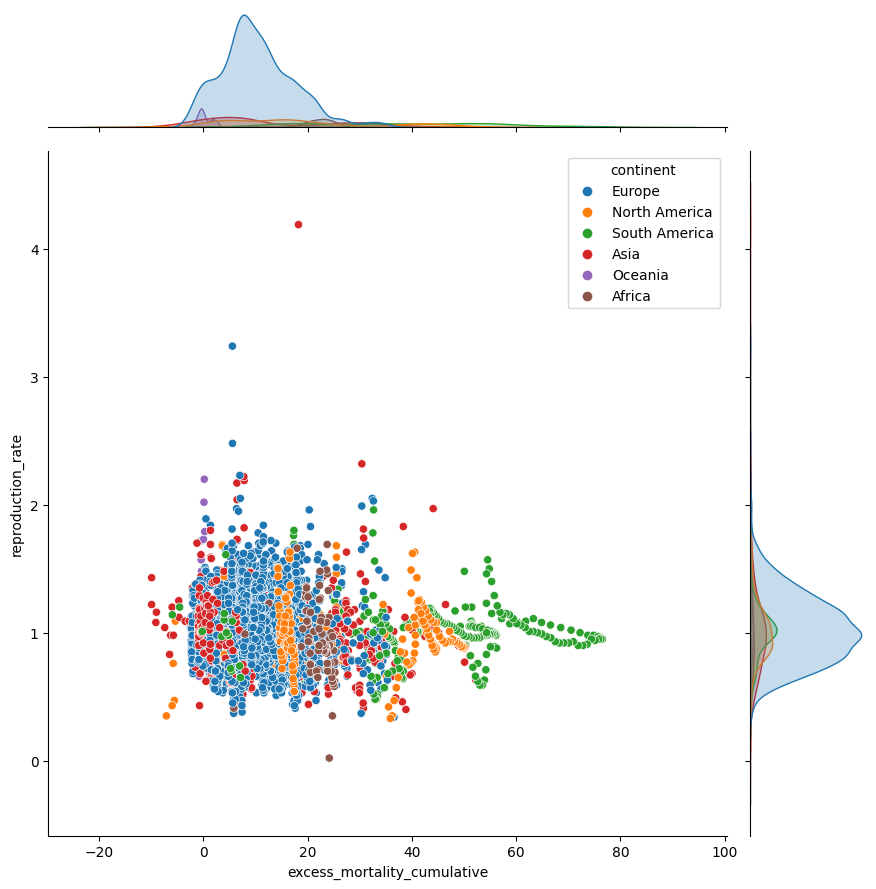

In [18]:
for predictor in predictors:
    sns.jointplot(data=df, x=predictor, y=target, hue=categorial, height=9)
    plt.plot()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,


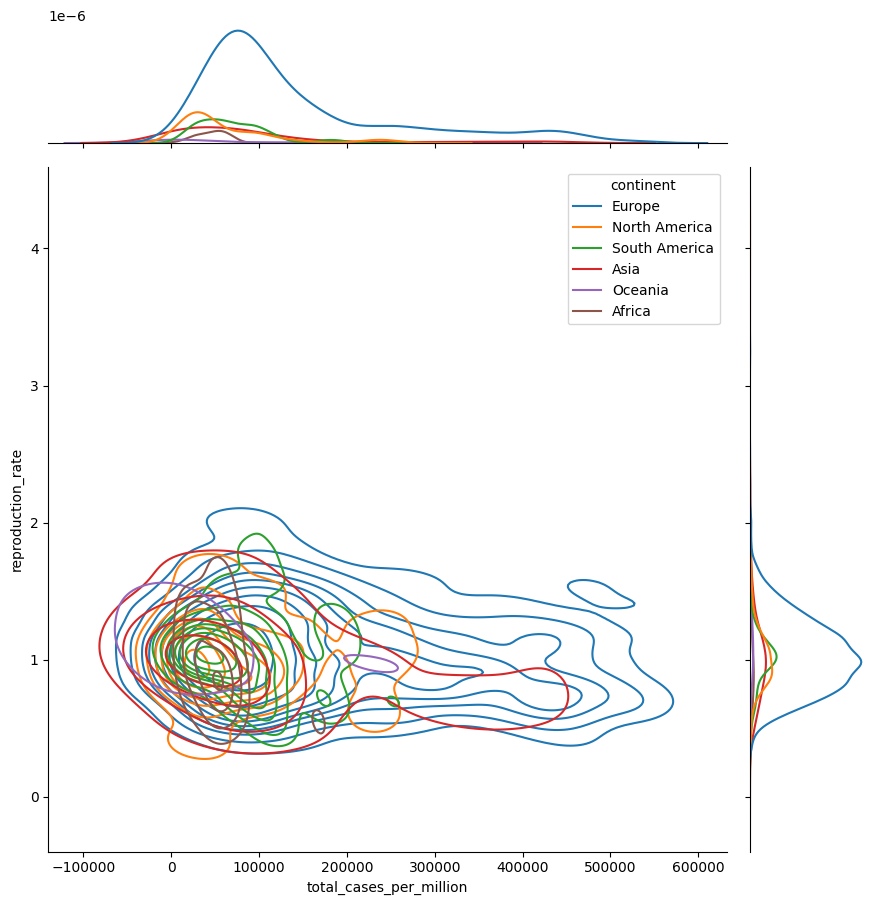

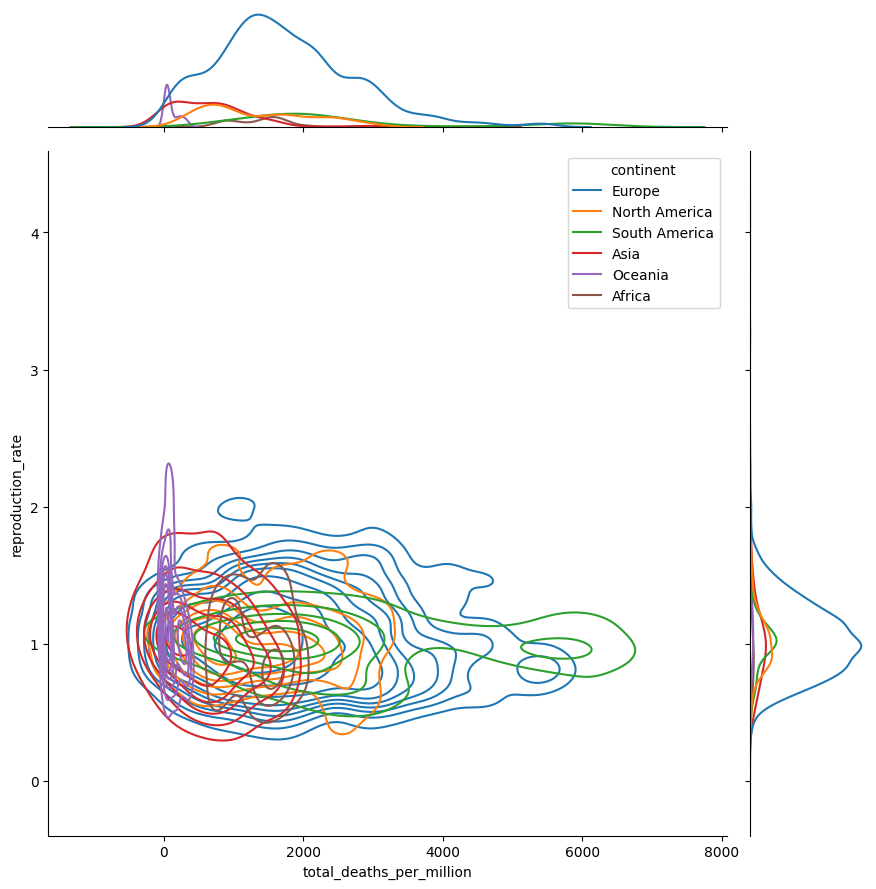

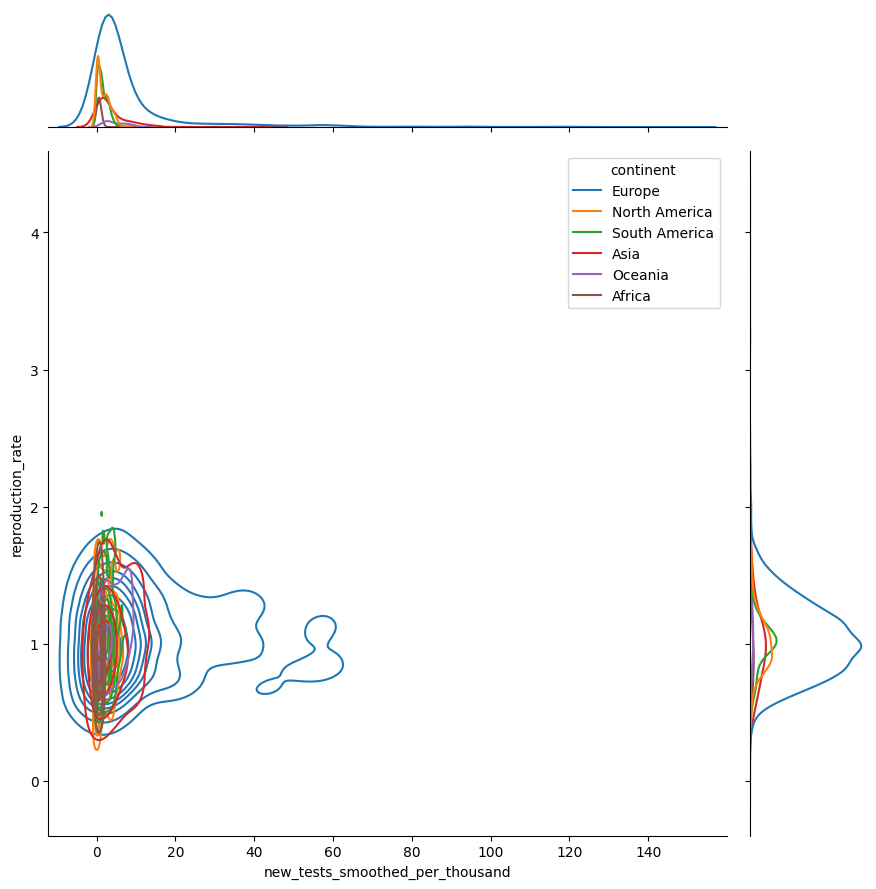

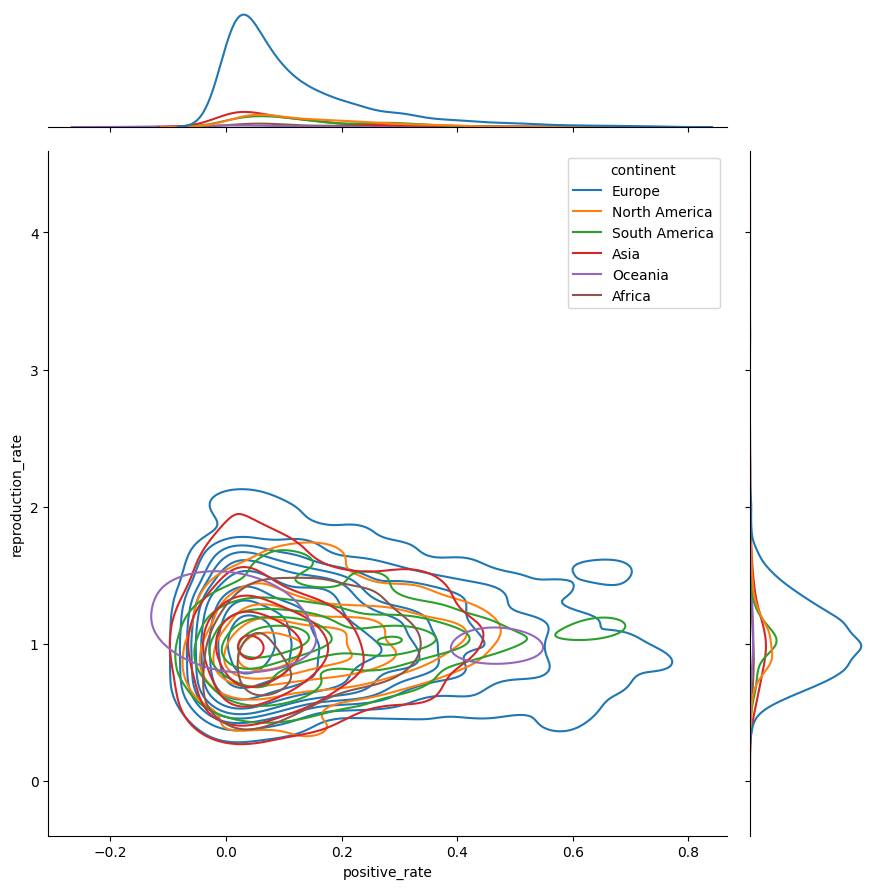

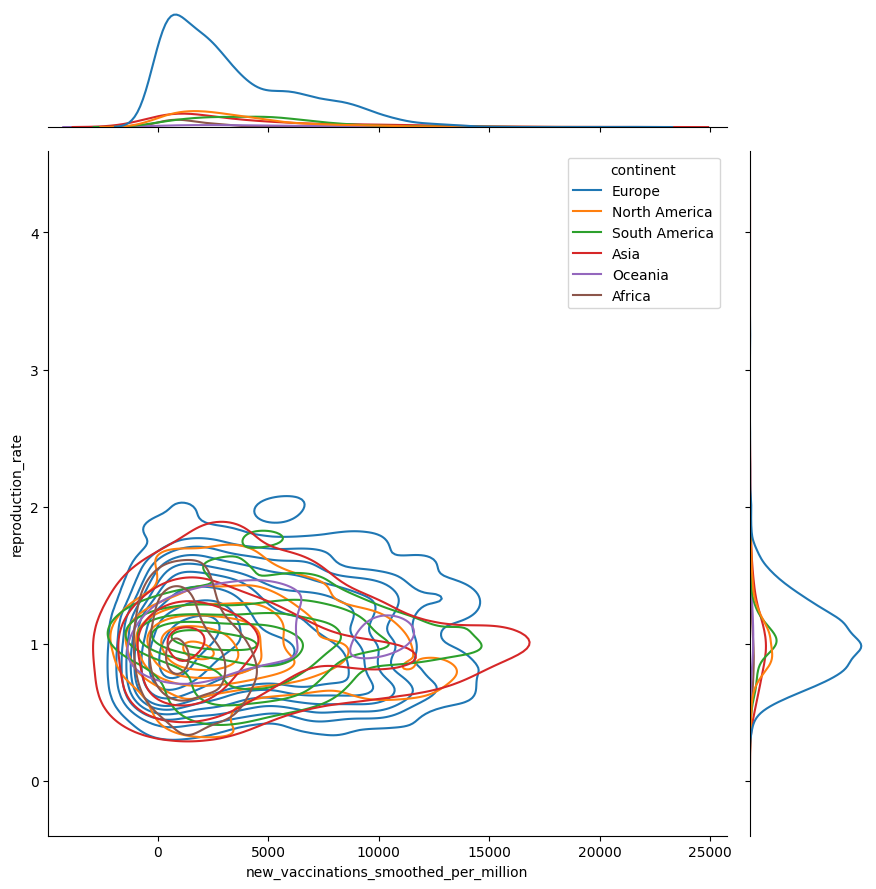

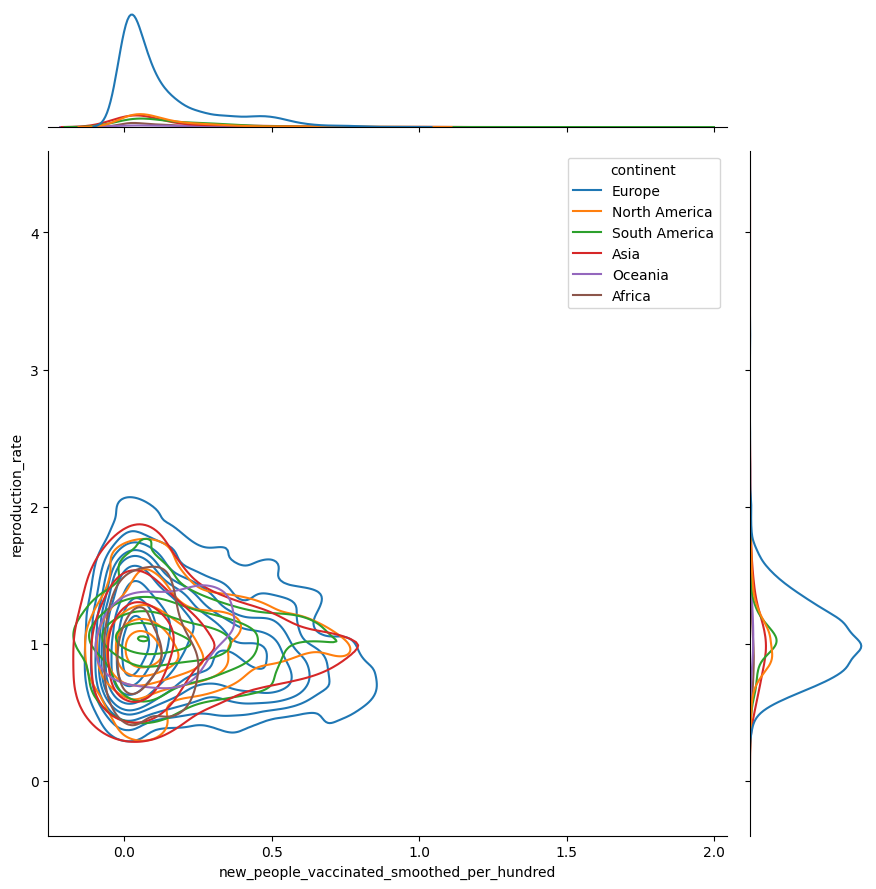

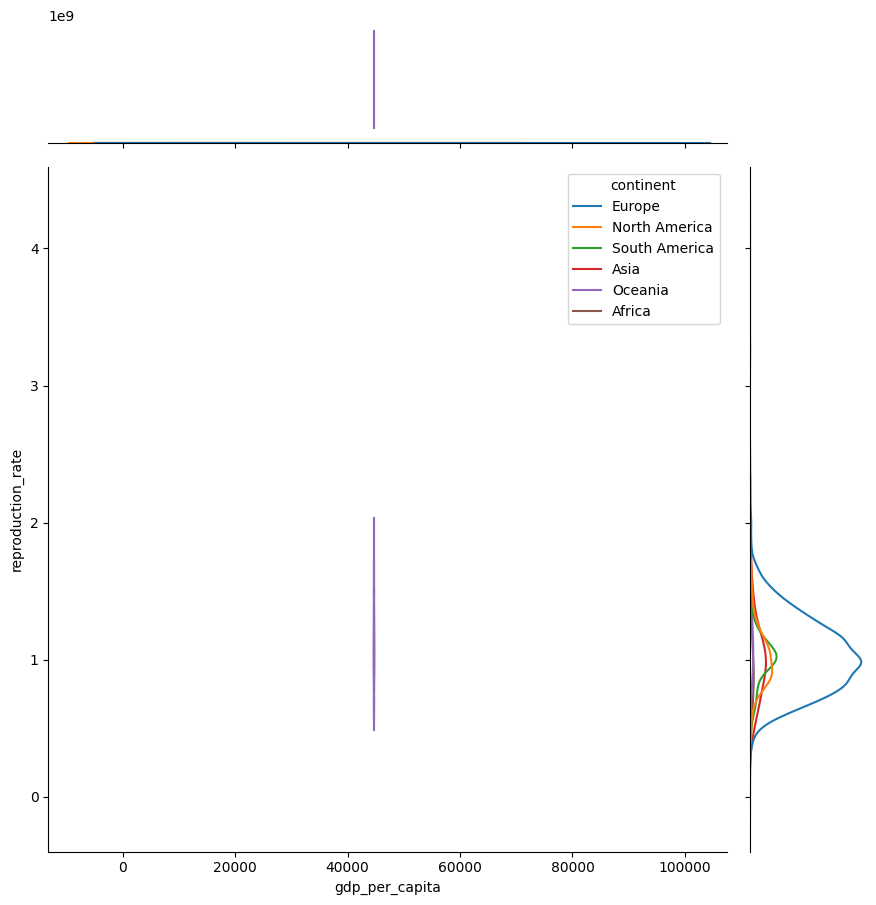

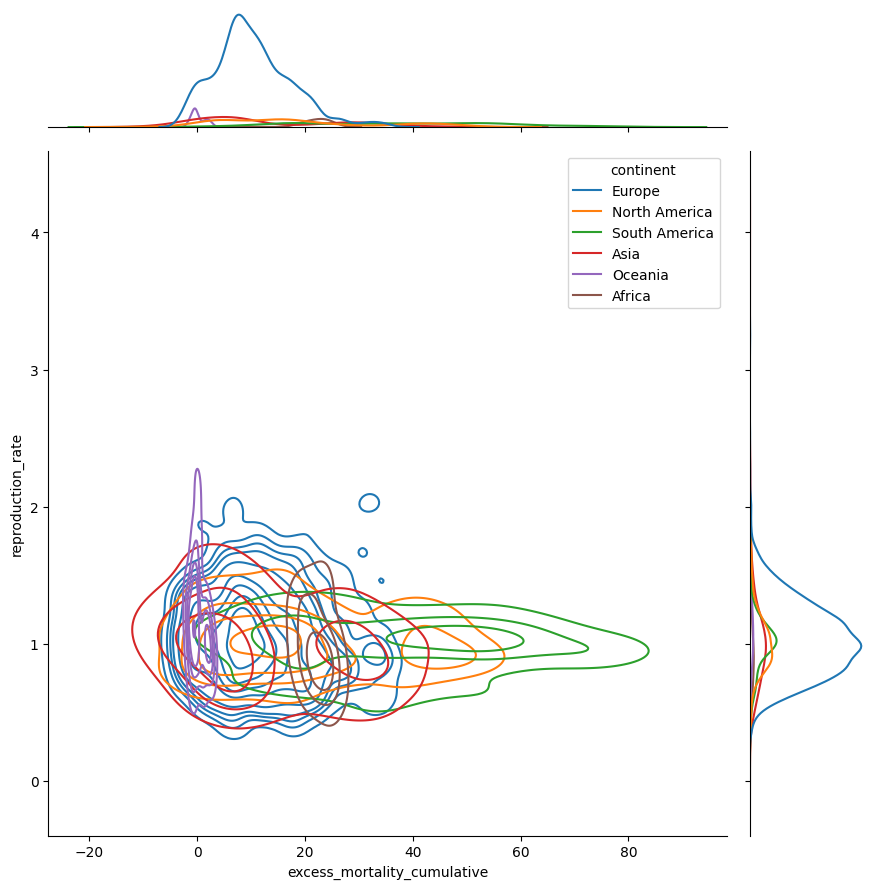

In [19]:
for predictor in predictors:
    sns.jointplot(data=df, x=predictor, y=target, kind='kde', hue=categorial, height=9)
    plt.plot()

In [20]:
# sns.pairplot(data=df[predictors + [target]], kind='kde', plot_kws={'levels':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]})

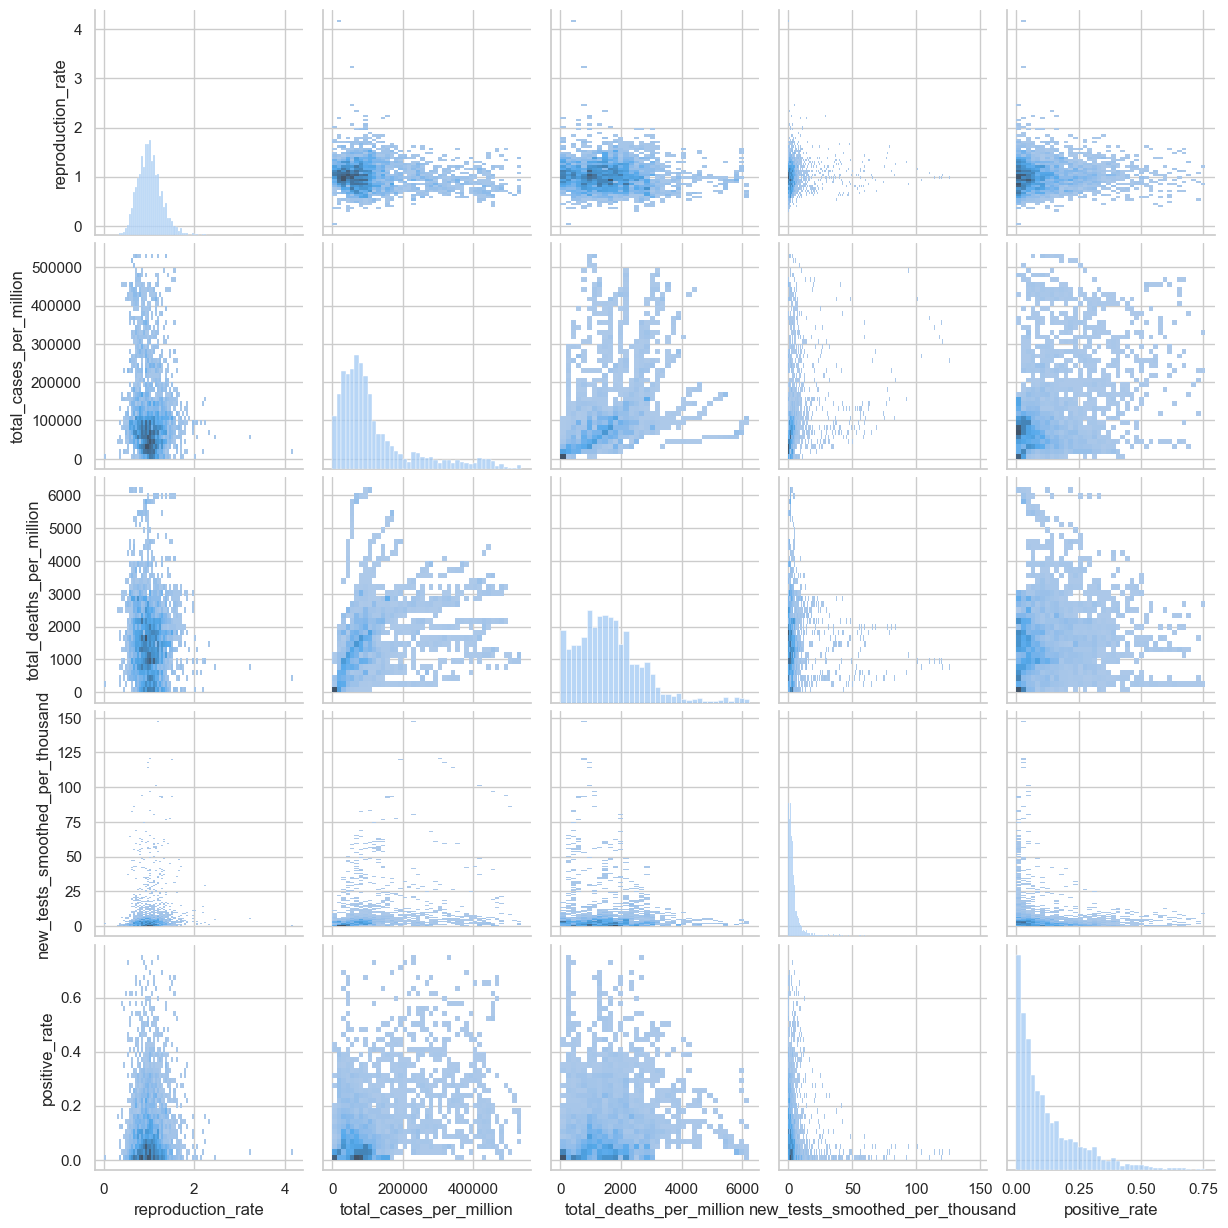

In [21]:
sns.set_theme(style='whitegrid', palette='pastel')

ax = sns.pairplot(df[['reproduction_rate',
           'total_cases_per_million',
            'total_deaths_per_million',
            'new_tests_smoothed_per_thousand',
            'positive_rate']], kind='hist', diag_kind='hist')
plt.show()

In [22]:
# ax = sns.pairplot(df[['reproduction_rate',
#            'total_cases_per_million',
#             'total_deaths_per_million',
#             'new_tests_smoothed_per_thousand',
#             'positive_rate']], diag_kind='kde')
# ax.map_lower(sns.kdeplot, levels=5, color='.1')

# plt.show()

## 2. Estimation of Multivariate Mathematical Expectation and Variance

In [53]:
df[columns].mean()

reproduction_rate                                  1.023385
total_cases_per_million                       119878.364158
total_deaths_per_million                        1617.485002
new_tests_smoothed_per_thousand                    6.443801
positive_rate                                      0.123713
new_vaccinations_smoothed_per_million           3508.352299
new_people_vaccinated_smoothed_per_hundred         0.139452
gdp_per_capita                                 32880.455968
excess_mortality_cumulative                       13.950828
dtype: float64

In [54]:
df[columns].var()

reproduction_rate                             7.484235e-02
total_cases_per_million                       1.217849e+10
total_deaths_per_million                      1.206947e+06
new_tests_smoothed_per_thousand               1.595720e+02
positive_rate                                 1.702659e-02
new_vaccinations_smoothed_per_million         1.004960e+07
new_people_vaccinated_smoothed_per_hundred    3.113892e-02
gdp_per_capita                                2.839982e+08
excess_mortality_cumulative                   1.721878e+02
dtype: float64

## 3. Non-parametric estimation of conditional distributions, mathematical expectations and variances

In [25]:
df_conditional = df[df.reproduction_rate == 1]
df_conditional

continent  reproduction_rate  total_cases_per_million  \
104         Oceania                1.0               298947.031   
160          Europe                1.0               296338.423   
206          Europe                1.0                62252.470   
270          Europe                1.0               348016.026   
283   North America                1.0                66121.371   
...             ...                ...                      ...   
3165         Europe                1.0               109357.933   
3267         Europe                1.0               374001.927   
3353         Europe                1.0               110055.741   
3426  North America                1.0               121717.416   
3473  South America                1.0               113628.741   

      total_deaths_per_million  new_tests_smoothed_per_thousand  \
104                    358.592                            2.374   
160                   2000.198                           60.851   
206                   1835.033                            4.286   
270                   2697.255                            1.647   
283                   1211.493                            3.655   
...                        ...                              ...   
3165                  1409.376                            1.955   
3267                  1535.730                            6.888   
3353                  2410.348                           15.506   
3426                  1944.572                            4.640   
3473                  1769.022                            2.066   

      positive_rate  new_vaccinations_smoothed_per_million  \
104          0.4426                                  331.0   
160          0.0490                                  681.0   
206          0.0520                                 1718.0   
270          0.2680                                  134.0   
283          0.1322                                 3810.0   
...             ...                                    ...   
3165         0.0297                                 2109.0   
3267         0.4950                                  268.0   
3353         0.0279                                 1202.0   
3426         0.0880                                 2063.0   
3473         0.0149                                 5532.0   

      new_people_vaccinated_smoothed_per_hundred  gdp_per_capita  \
104                                        0.005       44648.710   
160                                        0.007       45436.686   
206                                        0.055       42658.576   
270                                        0.001       42658.576   
283                                        0.196        7824.362   
...                                          ...             ...   
3165                                       0.046       46949.283   
3267                                       0.002       57410.166   
3353                                       0.031       39753.244   
3426                                       0.088       54225.446   
3473                                       0.035       20551.409   

      excess_mortality_cumulative  
104                          2.87  
160                          7.89  
206                         13.91  
270                          8.28  
283                         10.72  
...                           ...  
3165                         5.55  
3267                         7.53  
3353                        10.85  
3426                        15.40  
3473                         4.43  

[62 rows x 10 columns]

In [26]:
df_conditional[['total_cases_per_million',
            'total_deaths_per_million',
            'new_tests_smoothed_per_thousand',
            'positive_rate',
            'new_vaccinations_smoothed_per_million',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'excess_mortality_cumulative']].mean()

total_cases_per_million                       113775.970403
total_deaths_per_million                        1743.478855
new_tests_smoothed_per_thousand                    6.184790
positive_rate                                      0.135581
new_vaccinations_smoothed_per_million           3569.225806
new_people_vaccinated_smoothed_per_hundred         0.153016
gdp_per_capita                                 30048.161435
excess_mortality_cumulative                       18.273065
dtype: float64

In [27]:
df_conditional[['total_cases_per_million',
            'total_deaths_per_million',
            'new_tests_smoothed_per_thousand',
            'positive_rate',
            'new_vaccinations_smoothed_per_million',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'excess_mortality_cumulative']].var()

total_cases_per_million                       1.250462e+10
total_deaths_per_million                      1.921855e+06
new_tests_smoothed_per_thousand               2.875900e+02
positive_rate                                 1.613816e-02
new_vaccinations_smoothed_per_million         1.184156e+07
new_people_vaccinated_smoothed_per_hundred    4.130244e-02
gdp_per_capita                                3.001686e+08
excess_mortality_cumulative                   3.198207e+02
dtype: float64

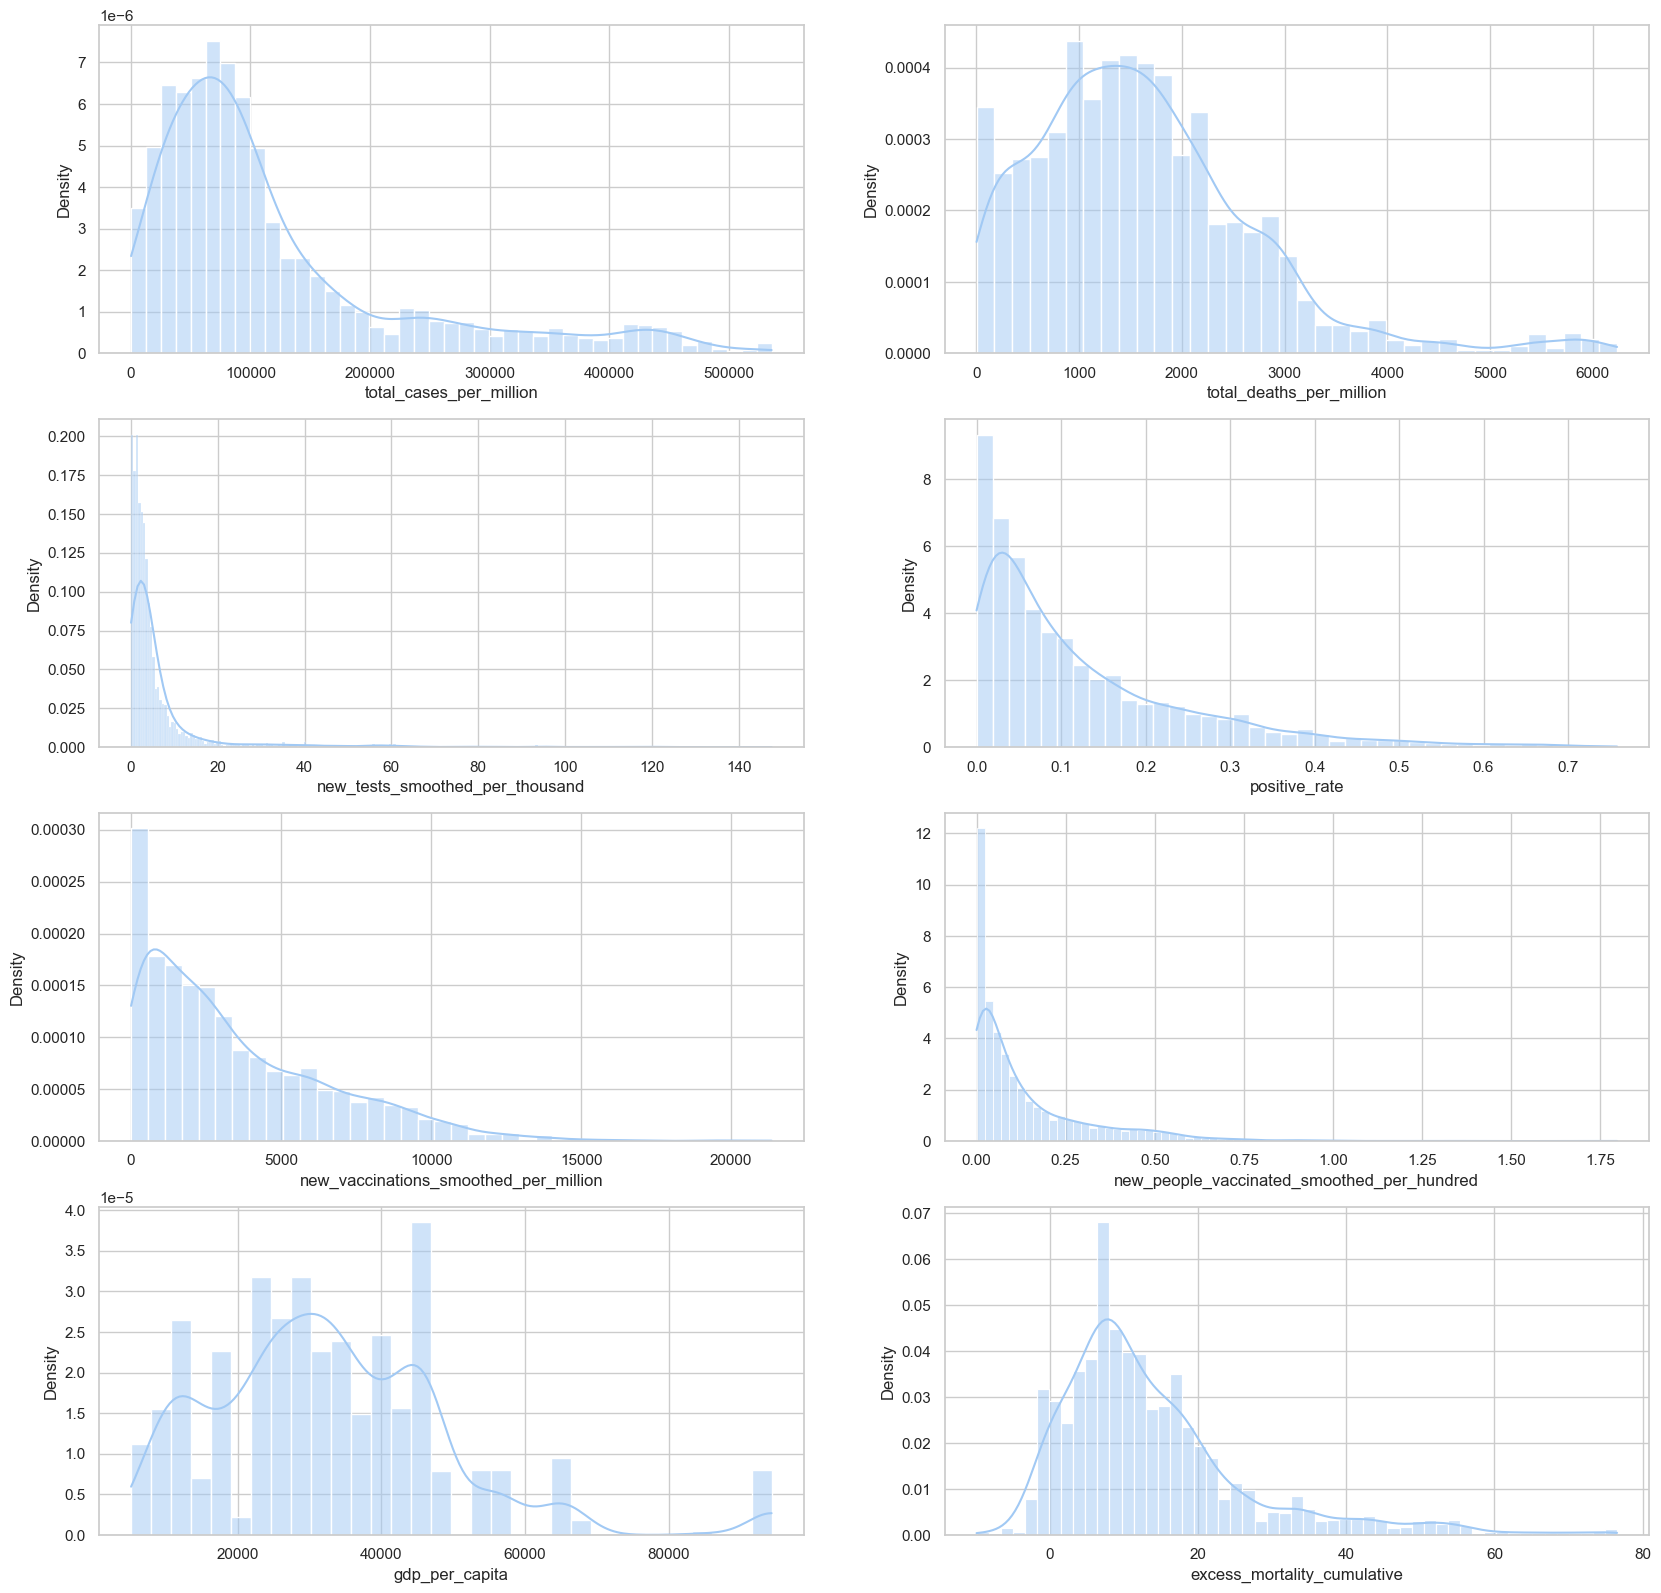

In [28]:
figure, ax = plt.subplots(4, 2, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

total_cases_per_million = sns.histplot(df.total_cases_per_million, ax=ax[0, 0], kde=True, stat='density')
total_cases_per_million.set(xlabel='total_cases_per_million')

total_deaths_per_million = sns.histplot(df.total_deaths_per_million, ax=ax[0, 1], kde=True, stat='density')
total_deaths_per_million.set(xlabel='total_deaths_per_million')

new_tests_smoothed_per_thousand = sns.histplot(df.new_tests_smoothed_per_thousand, ax=ax[1, 0], kde=True, stat='density')
new_tests_smoothed_per_thousand.set(xlabel='new_tests_smoothed_per_thousand')

positive_rate = sns.histplot(df.positive_rate, ax=ax[1, 1], kde=True, stat='density')
positive_rate.set(xlabel='positive_rate')

new_vaccinations_smoothed_per_million = sns.histplot(df.new_vaccinations_smoothed_per_million, ax=ax[2, 0], kde=True, stat='density')
new_vaccinations_smoothed_per_million.set(xlabel='new_vaccinations_smoothed_per_million')

new_people_vaccinated_smoothed_per_hundred = sns.histplot(df.new_people_vaccinated_smoothed_per_hundred, ax=ax[2, 1], kde=True, stat='density')
new_people_vaccinated_smoothed_per_hundred.set(xlabel='new_people_vaccinated_smoothed_per_hundred')

gdp_per_capita = sns.histplot(df.gdp_per_capita, ax=ax[3, 0], kde=True, stat='density')
gdp_per_capita.set(xlabel='gdp_per_capita')

excess_mortality_cumulative = sns.histplot(df.excess_mortality_cumulative, ax=ax[3, 1], kde=True, stat='density')
excess_mortality_cumulative.set(xlabel='excess_mortality_cumulative')

plt.show()

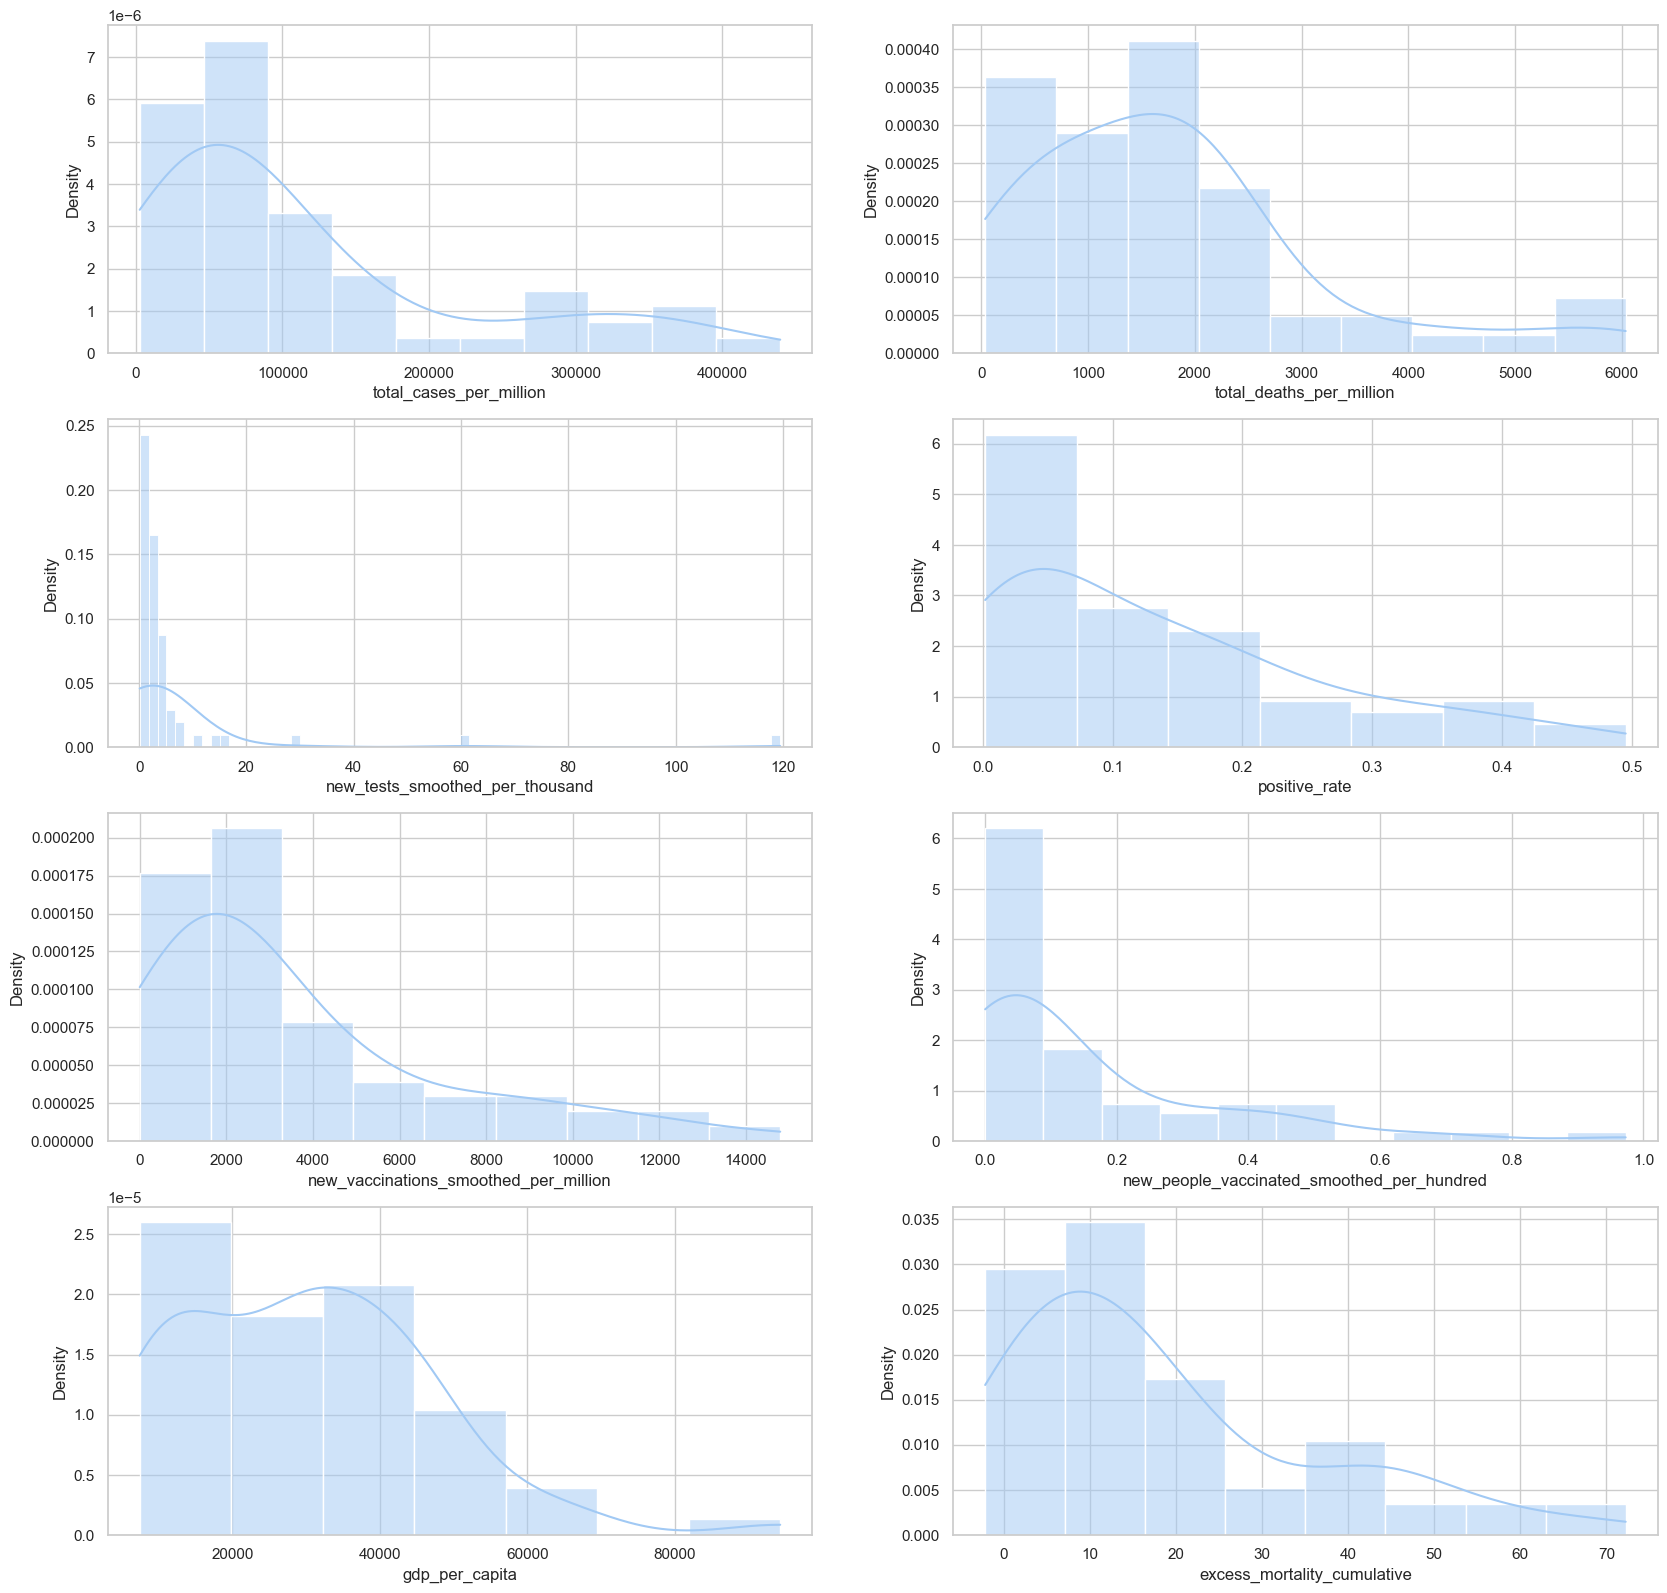

In [29]:
figure, ax = plt.subplots(4, 2, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

total_cases_per_million = sns.histplot(df_conditional.total_cases_per_million, ax=ax[0, 0], kde=True, stat='density')
total_cases_per_million.set(xlabel='total_cases_per_million')

total_deaths_per_million = sns.histplot(df_conditional.total_deaths_per_million, ax=ax[0, 1], kde=True, stat='density')
total_deaths_per_million.set(xlabel='total_deaths_per_million')

new_tests_smoothed_per_thousand = sns.histplot(df_conditional.new_tests_smoothed_per_thousand, ax=ax[1, 0], kde=True, stat='density')
new_tests_smoothed_per_thousand.set(xlabel='new_tests_smoothed_per_thousand')

positive_rate = sns.histplot(df_conditional.positive_rate, ax=ax[1, 1], kde=True, stat='density')
positive_rate.set(xlabel='positive_rate')

new_vaccinations_smoothed_per_million = sns.histplot(df_conditional.new_vaccinations_smoothed_per_million, ax=ax[2, 0], kde=True, stat='density')
new_vaccinations_smoothed_per_million.set(xlabel='new_vaccinations_smoothed_per_million')

new_people_vaccinated_smoothed_per_hundred = sns.histplot(df_conditional.new_people_vaccinated_smoothed_per_hundred, ax=ax[2, 1], kde=True, stat='density')
new_people_vaccinated_smoothed_per_hundred.set(xlabel='new_people_vaccinated_smoothed_per_hundred')

gdp_per_capita = sns.histplot(df_conditional.gdp_per_capita, ax=ax[3, 0], kde=True, stat='density')
gdp_per_capita.set(xlabel='gdp_per_capita')


excess_mortality_cumulative = sns.histplot(df_conditional.excess_mortality_cumulative, ax=ax[3, 1], kde=True, stat='density')
excess_mortality_cumulative.set(xlabel='excess_mortality_cumulative')

plt.show()

## 4. Estimation of pair correlation coefficients, confidence intervals for them and significance levels

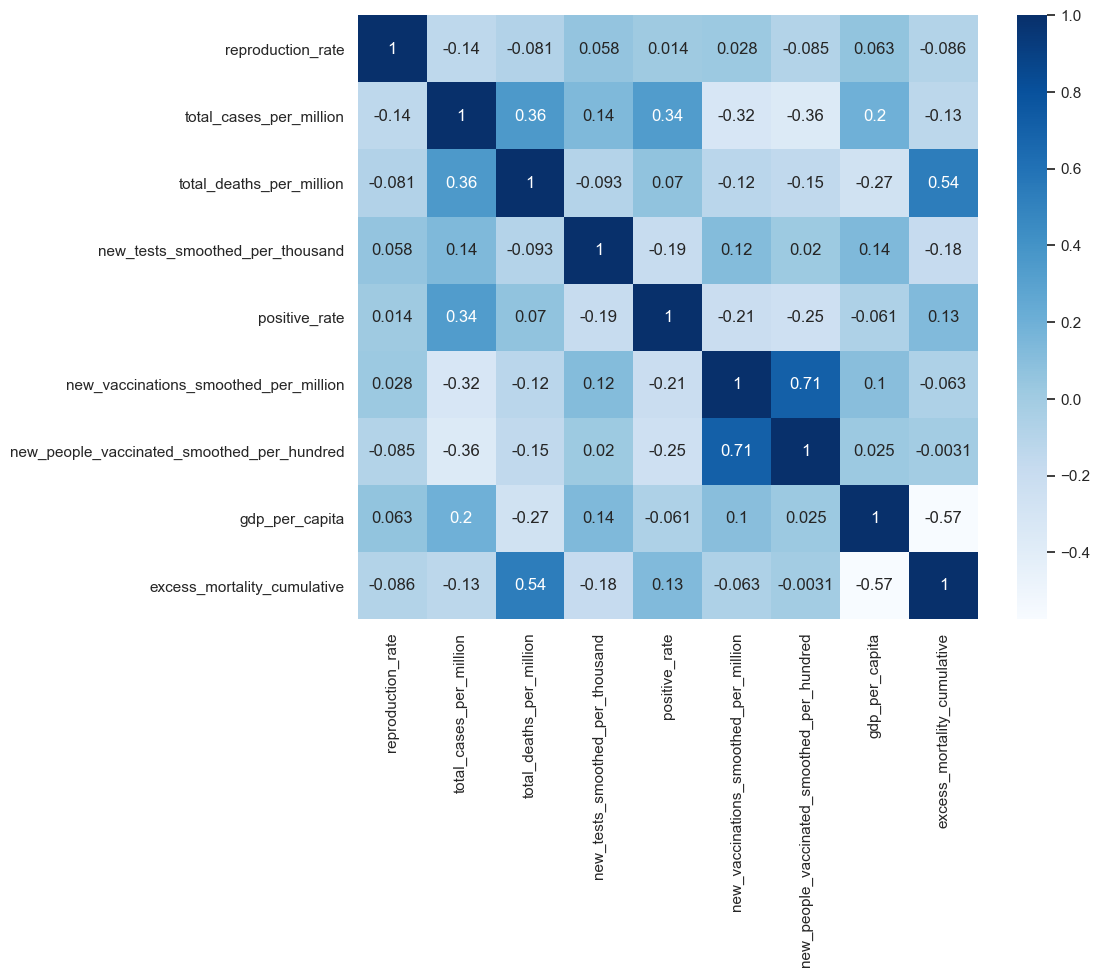

In [55]:
figure, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df[columns].corr(), cmap='Blues', annot=True)

plt.show()

In [31]:
def return_estimation(array, target, alpha=0.05):
    r, p_value = scipy.stats.pearsonr(array, target)
    
    r_to_z = np.arctanh(r) # Matches Fisher transform
    se = 1 / np.sqrt(array.size - 3) # Corresponding standard deviation
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_to_z-z*se, r_to_z+z*se
#   lo_z, hi_z = np.tanh(lo_z), np.tanh(hi_z)

    print('Correlation Coefficient: {:.4f}'.format(r))
    print('Confidence Interval for the correlation coefficient: ({:.4f}, {:.4f})'.format(lo_z, hi_z))
    print('Significance Level: {:.6f}'.format(p_value))

In [32]:
return_estimation(df.total_cases_per_million, df.total_deaths_per_million)

Correlation Coefficient: 0.3592
Confidence Interval for the correlation coefficient: (0.3427, 0.4092)
Significance Level: 0.000000


In [33]:
return_estimation(df.new_vaccinations_smoothed_per_million, df.excess_mortality_cumulative)

Correlation Coefficient: -0.0630
Confidence Interval for the correlation coefficient: (-0.0963, -0.0298)
Significance Level: 0.000202


In [34]:
return_estimation(df.new_people_vaccinated_smoothed_per_hundred, df.excess_mortality_cumulative)

Correlation Coefficient: -0.0031
Confidence Interval for the correlation coefficient: (-0.0363, 0.0302)
Significance Level: 0.856135


In [35]:
return_estimation(df.gdp_per_capita, df.excess_mortality_cumulative)

Correlation Coefficient: -0.5742
Confidence Interval for the correlation coefficient: (-0.6871, -0.6206)
Significance Level: 0.000000


In [36]:
return_estimation(df.total_cases_per_million, df.new_vaccinations_smoothed_per_million)

Correlation Coefficient: -0.3183
Confidence Interval for the correlation coefficient: (-0.3629, -0.2965)
Significance Level: 0.000000


## 5. Task formulation for regression. Estimate multivariate correlation (target - predictors)

Training a model for predicting reproduction_rate based on total_cases_per_million, total_deaths_per_million, new_tests_smoothed_per_thousand, positive_rate, new_vaccinations_smoothed_per_million, new_people_vaccinated_smoothed_per_hundred, gdp_per_capita, excess_mortality_cumulative variables.

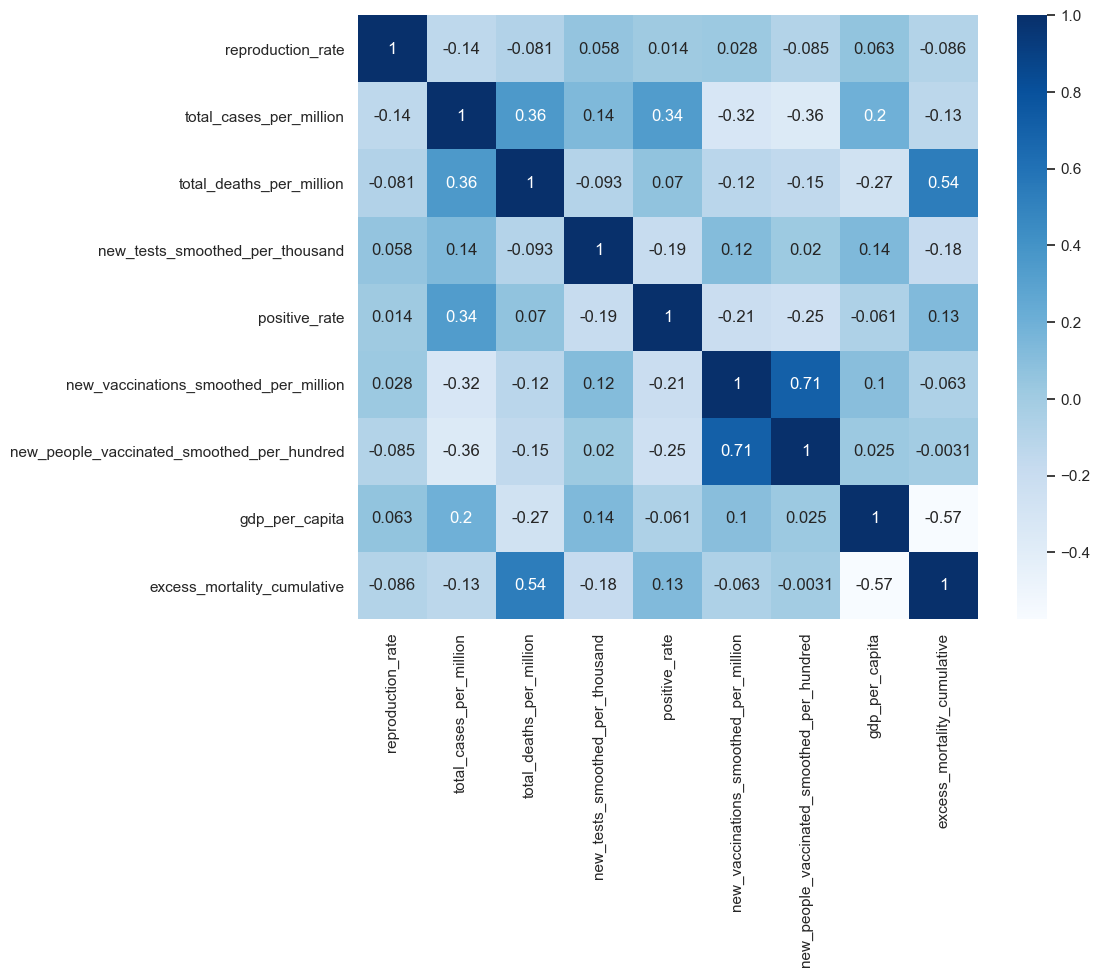

In [56]:
figure, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df[columns].corr(), cmap='Blues', annot=True)

plt.show()

## 6. Build regression model and make an analysis of multicollinearity and regularization (if needed)

In [38]:
# Highlight predictors
X = df[['total_cases_per_million',
            'total_deaths_per_million',
            'new_tests_smoothed_per_thousand',
            'positive_rate',
            'new_vaccinations_smoothed_per_million',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'excess_mortality_cumulative']]
# Allocate the target variable
y = df[['reproduction_rate']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression(normalize=True)
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [39]:
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
print('R2 Score = ', r2)

Mean absolute error =  0.1923381165450515
Mean squared error =  0.06535609277876754
R2 Score =  0.06377016273892222


In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape)

Mean absolute percentage error =  reproduction_rate    20.379919
dtype: float64


In [41]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print(clf.coef_)

[-5.35140969e-07  1.68332683e-05  1.26382258e-03  0.00000000e+00
 -4.45851555e-06 -0.00000000e+00  1.33202160e-06 -1.49544553e-03]


In [42]:
y_pred_lasso = clf.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print('Mean Absolute Error with lasso =', mae_lasso)
print('Mean Squared Error with lasso =', mse_lasso)
print('R2 Score with lasso =', r2_lasso)

Mean Absolute Error with lasso = 0.1935044440583066
Mean Squared Error with lasso = 0.06705982334101386
R2 Score with lasso = 0.03936412316082205


In [43]:
lars = Lars()
lars.fit(X_train, y_train)

mae = mean_absolute_error(y_test, lars.predict(X_test))
mse = mean_squared_error(y_test, lars.predict(X_test))
r2 = r2_score(y_test, lars.predict(X_test))
print('Mean Absolute Error with lars =', mae)
print('Mean Squared Error with lars =', mse)
print('R2 Score with lars =', r2)

Mean Absolute Error with lars = 0.1923381165450515
Mean Squared Error with lars = 0.06535609277876753
R2 Score with lars = 0.06377016273892244


## 7. Analyze the quality of regression model (distribution of residuals, determination coefficient)

Text(0, 0.5, 'reproduction rate')

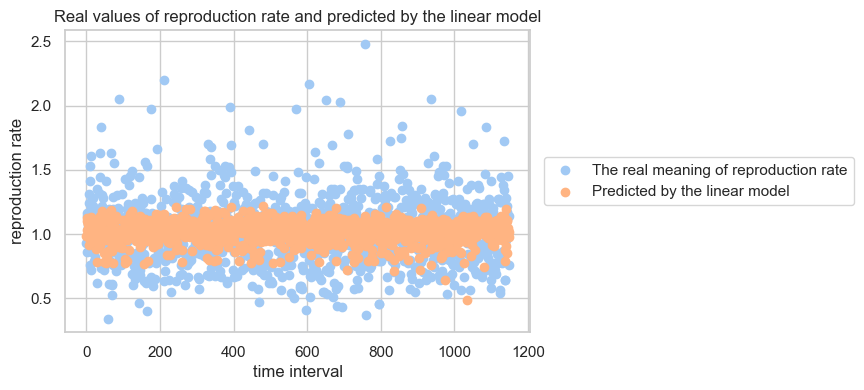

In [44]:
# Graph of real and predicted values
plt.scatter(x, y_test, label = u'The real meaning of reproduction rate')
plt.scatter(x, y_pred, label = u'Predicted by the linear model')
plt.title(u'Real values of reproduction rate and predicted by the linear model')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.xlabel(u'time interval')
plt.ylabel(u'reproduction rate')

In [45]:
y_pred_all = np.array(reg.predict(X))

Text(0, 0.5, 'Prediction')

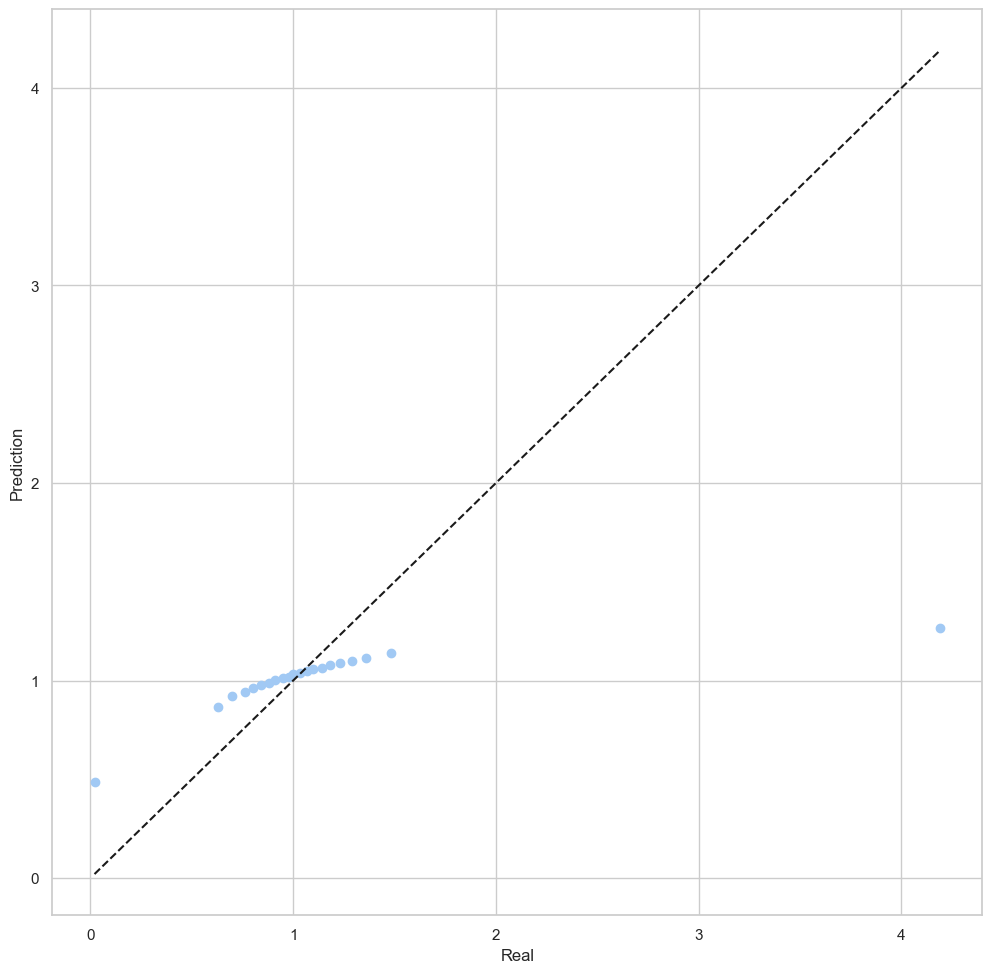

In [46]:
# Plotting a quantile biplot based on real and predicted values
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y, percs)
qn_second = np.percentile(y_pred_all, percs)
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')

In [47]:
# Building and training of the 2nd degree polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new = poly.fit_transform(X)
y_pred_poly_all = reg.predict(X_new)

Text(0, 0.5, 'Prediction')

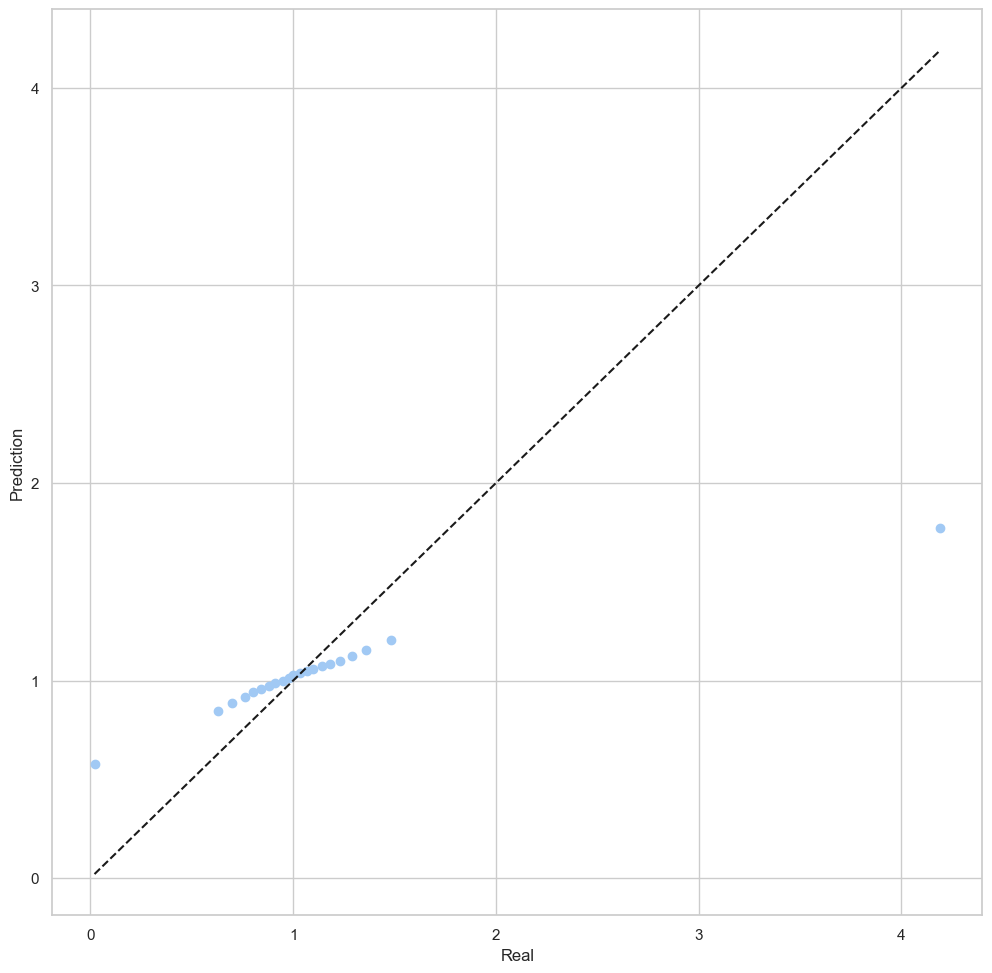

In [48]:
# Plotting a quantile biplot based on real and predicted values
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y, percs)
qn_second = np.percentile(y_pred_poly_all , percs)
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')

In [58]:
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print('Mean absolute error with Polynomial model = ', mae_poly)
print('Mean squared error with Polynomial model = ', mse_poly)
print('R2 Score with Polynomial model = ', r2)

Mean absolute error with Polynomial model =  0.18956160230088984
Mean squared error with Polynomial model =  0.06407821864119072
R2 Score with Polynomial model =  0.06377016273892244


Text(0, 0.5, 'reproduction rate')

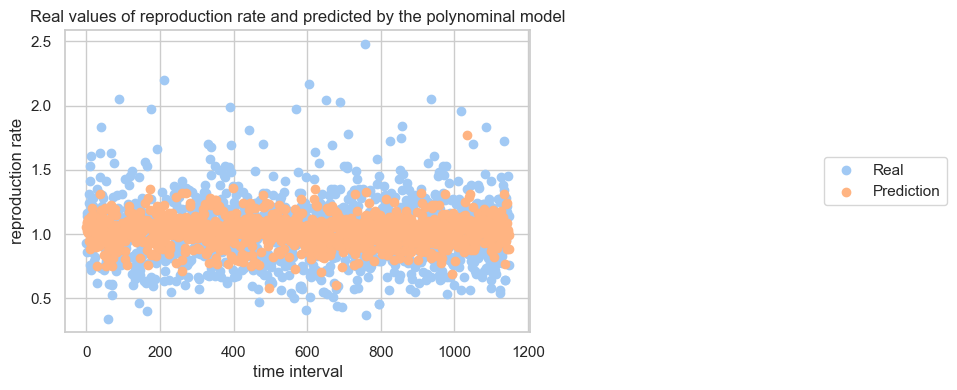

In [49]:
x = []
# Visualization of real and predicted values with polynominal model
for i in range(len(y_test)):
    x.append(i)
plt.scatter(x, y_test, label = u'Real')
plt.scatter(x, y_pred_poly, label = u'Prediction')
plt.title(u'Real values of reproduction rate and predicted by the polynominal model')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.9, 0.5))
plt.xlabel(u'time interval')
plt.ylabel('reproduction rate')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

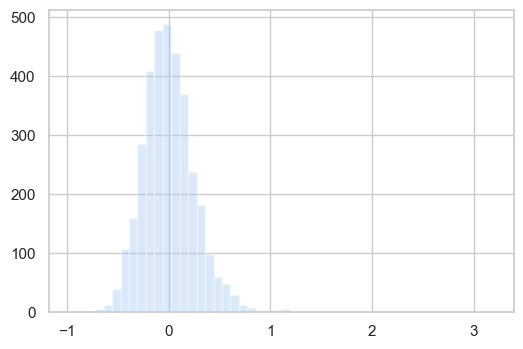

In [50]:
# Plotting the distribution of residuals
y1 = np.array(y)
y2 = np.array(y_pred_all)
y_diff = y1[:,0] - y2[:,0]
sns.distplot(y_diff, kde=False)

In [51]:
# Confidence interval of regression coef 
import numpy as np, statsmodels.api as sm
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print (res.conf_int(0.01))  

                                                       0             1
total_cases_per_million                    -8.315253e-07 -3.065669e-07
total_deaths_per_million                    7.420195e-05  1.260864e-04
new_tests_smoothed_per_thousand             4.017558e-03  7.307548e-03
positive_rate                               5.893598e-01  9.321734e-01
new_vaccinations_smoothed_per_million       1.731372e-05  3.541832e-05
new_people_vaccinated_smoothed_per_hundred -2.714395e-01  6.117958e-02
gdp_per_capita                              1.425285e-05  1.633377e-05
excess_mortality_cumulative                 8.211649e-03  1.238924e-02
